In [ ]:
import numpy as np
from PIL import Image

from siamese import Siamese

if __name__ == "__main__":
    model = Siamese()
    # /home/hechunjiang/gradio/样品2 SONY 43吋
    # /home/hechunjiang/gradio/样品3 亚马逊 43吋
    image_1 = Image.open("/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/样品1采集图像/2.jpg")
    image_2 = Image.open("/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/2.jpg")
    # image_1 = Image.open("/data/hechunjiang/KADID-10k/kadid10k/images/I01_01_05.png")
    # image_2 = Image.open("/data/hechunjiang/KADID-10k/kadid10k/images/I01.png")
    # image_1 = Image.open("/home/hechunjiang/gradio/GeoFormer/croped_result/finetune_dst/2/cropped_image_28.png")
    # image_2 = Image.open("/home/hechunjiang/gradio/GeoFormer/croped_result/finetune_ref/2/cropped_image_28.png")
    probability = model.detect_image(image_1,image_2)
    print(probability)

Loading weights into state dict...


/home/hechunjiang/software/anaconda3/envs/siamese/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hechunjiang/software/anaconda3/envs/siamese/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/hechunjiang/gradio/Siamese-pytorch/siamese.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future r

/home/hechunjiang/gradio/Siamese-pytorch/model_data/best_epoch_weights_resnet.pth model loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path | /home/hechunjiang/gradio/Siamese-pytorch/model_data/best_epoch_weights_resnet.pth|
|              input_shape |                               [256, 256]|
|          letterbox_image |                                    False|
|                     cuda |                                     True|
----------------------------------------------------------------------
tensor([0.2650], device='cuda:0')


In [ ]:
import numpy as np
from PIL import Image
import json

from omegaconf import OmegaConf
from siamese import Siamese
import os

scores = [[] for _ in range(22)]

res = [[] for _ in range(22)]

scores_json = {}

demo = "SONY"

if __name__ == "__main__":
    # 1. 准备配置
    config_list = {
        # "model_path": logs_path + "/best_epoch_weights.pth",
        "model_name": 'vgg16',
        # "model_path": '/home/hechunjiang/gradio/Siamese-pytorch/logs-finetune-4-qingxidu/best_epoch_weights.pth',
        "model_path": '/home/hechunjiang/gradio/Siamese-pytorch/logs-finetune-4-qingxidu/best_epoch_weights.pth',
        "image_size": [256, 256],
    }
    config_ = OmegaConf.create(config_list)

    # 2. 加载模型
    model = Siamese(config_)
    img_list_1 = []
    img_list_2 = []
    for i in range(1, 4):
        img_list_1 = os.listdir(
            f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_dst/{i}/")
        img_list_2 = os.listdir(
            f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_ref/{i}/")
        # 过滤掉.json文件
        img_list_1 = [x for x in img_list_1 if x.endswith(".png")]
        img_list_2 = [x for x in img_list_2 if x.endswith(".png")]
        img_list_1.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        img_list_2.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        for path1, path2 in zip(img_list_1, img_list_2):
            image_1 = Image.open(
                f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_dst/{i}/{path1}")
            image_2 = Image.open(
                f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_ref/{i}/{path2}")
            scores[i].append(model.detect_image(
                image_1, image_2).cpu().numpy())
            
        json_ref = f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_ref/{i}/cropped_image_coordinate.json"
        coordinates_ref = []
        with open(json_ref, "r") as f:
            coordinates_ref = json.load(f)["coordinates"]

        label_json_ref = f"/home/hechunjiang/gradio/src/result/attention_area/{i}.json"
        label_ref = []

        # 如果label_json_ref不存在，则跳过
        if not os.path.exists(label_json_ref):
            continue
        with open(label_json_ref, "r") as f:
            label_ref = json.load(f)["points"]

        # 对于每一个coordinates_ref中的框，计算其和label_ref中每一个框的iou
        for idx, coordinate in enumerate(coordinates_ref):
            for label in label_ref:
                # 计算iou
                iou = calculate_iou(coordinate, label)
                if iou >= 0.5:
                    res[i].append(scores[i][idx])
                    break
        
        score = np.array(0)
        if len(scores[i]) != 0:
            score = sum(res[i]) / len(res[i])

        # scores_json[str(i)] = {}
        # # 将scores[]的每个元素转换为list
        # scores[i] = [x.tolist() for x in scores[i]]
        # scores_json[str(i)]["all_socres"] = scores[i]

        # scores_json[str(i)]["average"] = score.tolist()
        # 保存json
        # import json
        # with open("scores_LG_finetune_baipingheng.json", "w") as f:
        #     json.dump(scores_json, f, indent=4)

        print(score[0])

Inferencing, loading weights into state dict...


/home/hechunjiang/gradio/Siamese-pytorch/siamese.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_path, map_location=device))

vgg16 model loaded, model path: /home/hechunjiang/gradio/Siamese-pytorch/logs-finetune-4-qingxidu/best_epoch_weights.pth
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_name |                                    vgg16|
|               model_path | /home/hechunjiang/gradio/Siamese-pytorch/logs-finetune-4-qingxidu/best_epoch_weights.pth|
|               image_size |                               [256, 256]|
----------------------------------------------------------------------
-0.18904771
-0.1508856
-0.5888285


In [13]:
res[i]

array([-0.9971349], dtype=float32)

In [9]:
s = [[] for _ in range(22)]
for i in range(22):
    for x in scores[i]:
        s[i].append(x[0])

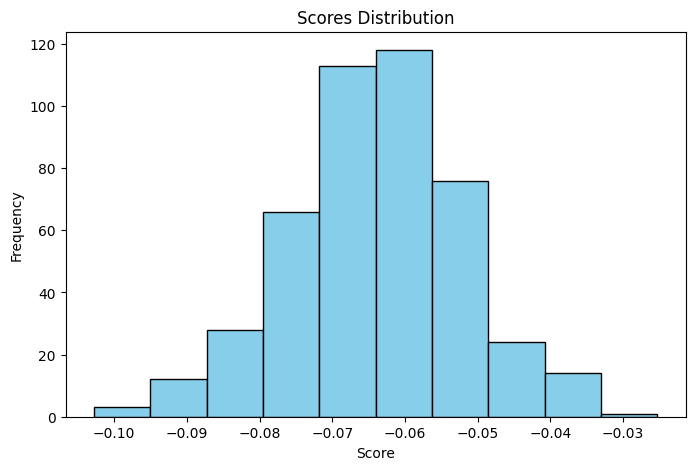

In [12]:
import matplotlib.pyplot as plt
img_idx = 1
# 绘制直方图
plt.figure(figsize=(8, 5))
plt.hist(s[img_idx], bins=10, color='skyblue', edgecolor='black')
plt.title('Scores Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
%matplotlib inline
import numpy as np
from PIL import Image
import json

from siamese import Siamese
import os
from PIL import ImageDraw

scores_LG_org = [[] for _ in range(22)]
scores_LG_avg = [[] for _ in range(22)]
scores_LG_weighted = [[] for _ in range(22)]
positive_weight = 1.3
negative_weight = 0.7


def show_box(img1, coordinates_ref, label_ref):
    image_1 = Image.open(img1)
    draw = ImageDraw.Draw(image_1)
    for coordinate in coordinates_ref:
        draw.rectangle([coordinate['left'], coordinate['top'], coordinate['right'], coordinate['bottom']], outline="red")
    # 将label_ref中的框绘制到image_1上
    for label in label_ref:
        draw.rectangle([label['x1'], label['y1'], label['x2'], label['y2']], outline="green", width=4)
    display(image_1)

def calculate_iou(box1, box2):
    """
    计算红色框在绿色框中的占比
    box1是红色框，box2是绿色框
    Parameters
    """

    x_left = max(box1['left'], box2['x1'])
    y_top = max(box1['top'], box2['y1'])
    x_right = min(box1['right'], box2['x2'])
    y_bottom = min(box1['bottom'], box2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left + 1.0) * (y_bottom - y_top + 1.0)
    
    box1_area = (box1['right'] - box1['left'] + 1.0) * (box1['bottom'] - box1['top'] + 1.0)
    box2_area = (box2['x2'] - box2['x1'] + 1.0) * (box2['y2'] - box2['y1'] + 1.0)
    # return intersection_area / (box1_area + box2_area - intersection_area)
    
    # 计算红色框和绿色框相交面积占红色框的比例
    iou = intersection_area / box1_area
    return iou


scores_LG_path = "/home/hechunjiang/gradio/Siamese-pytorch/scores_LG_resnet.json"

if __name__ == "__main__":
    with open(scores_LG_path, "r") as f:
        scores_LG = json.load(f)
        for i in range(1, 22):
            scores_LG_org[i] = (scores_LG[str(i)]["all_socres"])
            scores_LG_avg[i] = (scores_LG[str(i)]["average"])

    for i in range(1, 22):
        json_ref = f"/home/hechunjiang/gradio/GeoFormer/croped_result_LG/finetune_ref/{i}/cropped_image_coordinate.json"
        coordinates_ref = []
        with open(json_ref, "r") as f:
            coordinates_ref = json.load(f)["coordinates"]

        label_json_ref = f"/home/hechunjiang/gradio/src/result/attention_area/{i}.json"
        label_ref = []

        # 如果label_json_ref不存在，则跳过
        if not os.path.exists(label_json_ref):
            continue
        with open(label_json_ref, "r") as f:
            label_ref = json.load(f)["points"]

    
        # 对于每一个coordinates_ref中的框，计算其和label_ref中每一个框的iou
        for idx, coordinate in enumerate(coordinates_ref):
            flag = False
            for label in label_ref:
                # 计算iou
                iou = calculate_iou(coordinate, label)
                if iou >= 0.5:
                    scores_LG_weighted[i].append([x * positive_weight for x in scores_LG_org[i][idx]])
                    flag = True
                    break
            if not flag:
                scores_LG_weighted[i].append([x * negative_weight for x in scores_LG_org[i][idx]])
        
        # 计算加权平均
        score = 0
        if len(scores_LG_weighted[i]) != 0:
            flattened_scores = [item for sublist in scores_LG_weighted[i] for item in sublist]
            score = sum(flattened_scores) / len(flattened_scores)
        print(score)
        # print(f"image {i} avg_score = {scores_LG_avg[i]}")
        # 读取img1的图片，将coordinates_ref中的框绘制到image_1上
        # img1 = f"/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/样品1采集图像/{i}.jpg"
        # show_box(img1, coordinates_ref, label_ref)
        

0.03259512945956478
0.002399473596487913
-0.6402057106105916
0.013034441699720418
0.18227083233368271
0.033738710035103016
-0.09011347186760495
-0.001472821416414298
0.023783737812191275
0.6085677814958939
-0.2127333081163603
0.05923954458616294
-0.02676208384747735
0.06833872634829684
-0.045599069870237555
-0.03340983735186983
-0.05716338464442415
0.12282741922689114
0.18059747687439975
0.1859407992084364
-0.29084345607806267


In [ ]:
%matplotlib inline
import numpy as np
from PIL import Image
import json

from siamese import Siamese
import os
from PIL import ImageDraw

def show_box(img1, coordinates_ref, label_ref):
    image_1 = Image.open(img1)
    draw = ImageDraw.Draw(image_1)
    for coordinate in coordinates_ref:
        draw.rectangle([coordinate['left'], coordinate['top'],
                       coordinate['right'], coordinate['bottom']], outline="red")
    # 将label_ref中的框绘制到image_1上
    for label in label_ref:
        draw.rectangle([label['x1'], label['y1'], label['x2'],
                       label['y2']], outline="green", width=4)
    # image_1.show()
    display(image_1)


i = 20

json_ref = f"/home/hechunjiang/gradio/GeoFormer/croped_result_KTC/finetune_ref/{i}/cropped_image_coordinate.json"
coordinates_ref = []
with open(json_ref, "r") as f:
    coordinates_ref = json.load(f)["coordinates"]

# label_json_ref = f"/home/hechunjiang/gradio/src/result/attention_area/{i}.json"
label_json_ref = f"/home/hechunjiang/gradio/src/result/attention_area/KTC/transformed_attention_{i}.json"
label_ref = []
if os.path.exists(label_json_ref):
    with open(label_json_ref, "r") as f:
        label_ref = json.load(f)["points"]

show_box(
    f"/home/hechunjiang/gradio/aligned_imgs/KTC/{i}.jpg", coordinates_ref, label_ref)
iou = []
iou_threshold = []
for idx, coordinate in enumerate(coordinates_ref):
    for label in label_ref:
        # 计算iou
        val = calculate_iou(coordinate, label)
        if (val >= 0.5):
            iou_threshold.append(val)
        iou.append(val)
    # print(iou)

%matplotlib inline
import matplotlib.pyplot as plt
# 绘制直方图
plt.figure(figsize=(8, 5))
plt.hist(iou, bins=10, color='skyblue', edgecolor='black')
plt.title('Scores Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# 生成微调数据

## 加高斯模糊，再切分图片

In [28]:
def calculate_iou(box1, box2):
    """
    计算红色框在绿色框中的占比
    box1是红色框，box2是绿色框
    Parameters
    """

    x_left = max(box1['left'], box2['x1'])
    y_top = max(box1['top'], box2['y1'])
    x_right = min(box1['right'], box2['x2'])
    y_bottom = min(box1['bottom'], box2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left + 1.0) * (y_bottom - y_top + 1.0)
    
    box1_area = (box1['right'] - box1['left'] + 1.0) * (box1['bottom'] - box1['top'] + 1.0)
    box2_area = (box2['x2'] - box2['x1'] + 1.0) * (box2['y2'] - box2['y1'] + 1.0)
    # return intersection_area / (box1_area + box2_area - intersection_area)
    
    # 计算红色框和绿色框相交面积占红色框的比例
    iou = intersection_area / box1_area
    return iou

In [5]:
import time
from PIL import Image
import os
import json
import cv2


def crop_image(image_path, coordinates_path, radius, img_idx, demo_name=""):

    # 检查图像路径是否存在
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    print(f"Processing image: {image_path}")

    image = cv2.imread(image_path)

    # 检查坐标文件是否存在
    if not os.path.exists(coordinates_path):
        raise ValueError(f"Coordinates file not found: {coordinates_path}")
    with open(coordinates_path, 'r') as json_file:
        coordinates = json.load(json_file)

    # 记录开始的时间
    start_time = time.time()

    # 记录裁剪的图块的地址
    cropped_image_paths = []

    result_dir = f'/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo_name}/{img_idx}/radius_{radius}/'

    # 检查目录是否存在，如果不存在则创建
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    for i, data in enumerate(coordinates['coordinates']):
        # 根据坐标裁剪图块
        left = data['left']
        top = data['top']
        right = data['right']
        bottom = data['bottom']

        left = round(left)
        top = round(top)
        right = round(right)
        bottom = round(bottom)

        cropped_image = image[top:bottom, left:right]
        cropped_image_save_path = os.path.join(
            result_dir, f"cropped_image_{i}.png")

        cv2.imwrite(cropped_image_save_path, cropped_image)
        cropped_image_paths.append(cropped_image_save_path)

    # 记录结束的时间
    end_time = time.time()
    print(f"Time elapsed, crop img: {end_time - start_time} seconds")

    return cropped_image_paths

In [6]:
%matplotlib inline
from PIL import Image, ImageFilter
import os
import pandas as pd

demo = 'LG'
# demo = 'SONY'
# demo = 'AMAZON'
radius_list = [1, 3, 5]
# 35 25 10
scores = [[], [-1.2, -1.6, -2.0, -3.0], [-0.2, -0.6, -1.0, -2.0], [-1.5, -2.5, -4.0, -4.0]] # 样品1
# scores = [[], [0.13, -0.27, -0.67, -1.67], [0.13, -0.27, -0.67, -1.67], [0.8, 0.4, 0, -1.0]] # 样品2
# scores = [[], [-1.87, -2.27, -2.67, -3.67], [-1.54, -1.94, -2.34, -3.34], [-1.2, -1.6, -2.0, -3.0]] # 样品3
for i in range(3, 4):
    image_path = f"/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/样品1采集图像/{i}.jpg" # 样品1
    # image_path = f"/home/hechunjiang/gradio/样品2 SONY 43吋/华为P50手机采集图像/{i}.jpg" # 样品2
    # image_path = f"/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/{i}.jpg" # 样品3
    frame_image = Image.open(image_path)
    for j in range(len(radius_list)):
        radius = radius_list[j]
        gaussian_blur_img = frame_image.filter(ImageFilter.GaussianBlur(radius=radius))
        gaussian_blur_save_path = f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/{i}/radius_{radius}.jpg"
        if not os.path.exists(os.path.dirname(gaussian_blur_save_path)):
            os.makedirs(os.path.dirname(gaussian_blur_save_path))
        gaussian_blur_img.save(gaussian_blur_save_path)

        # 读取dst坐标文件，按照坐标文件的坐标对图片进行裁剪
        coordinate_path = f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_dst/{i}/cropped_image_coordinate.json"
        dst_img_list = crop_image(gaussian_blur_save_path, coordinate_path, radius, i,demo_name=demo)

        # 读取ref的图片，形成文件名称的list
        ref_image_path = f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_ref/{i}/"
        ref_image_list = os.listdir(ref_image_path)
        ref_image_list = [x for x in ref_image_list if x.endswith(".png")]
        ref_image_list.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

        assert len(dst_img_list) == len(ref_image_list)

        # 根据attention_area中的坐标筛选dst_img_list和ref_image_list
        label_json_ref = f"/home/hechunjiang/gradio/src/result/attention_area/{i}.json"
        label_ref = []
        if os.path.exists(label_json_ref):
            with open(label_json_ref, "r") as f:
                label_ref = json.load(f)["points"]

        # 读取ref的坐标文件
        json_ref = f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_ref/{i}/cropped_image_coordinate.json"
        coordinates_ref = []
        with open(json_ref, "r") as f:
            coordinates_ref = json.load(f)["coordinates"]

        # 保存符合条件的dst_img_list和ref_image_list
        dst_img_list_filtered = []
        ref_image_list_filtered = []
        for idx, coordinate in enumerate(coordinates_ref):
            for label in label_ref:
                # 计算iou
                iou = calculate_iou(coordinate, label)
                if iou >= 0.5:
                    dst_img_list_filtered.append(dst_img_list[idx])
                    ref_image_list_filtered.append(ref_image_list[idx])
                    break
        print(f"dst_img_list_filtered = {len(dst_img_list_filtered)}" + f" ref_image_list_filtered = {len(ref_image_list_filtered)}")

        dst_img_list = dst_img_list_filtered
        ref_image_list = ref_image_list_filtered

        # 将r, ref_image_list, scores[i][j]保存到csv文件中
        df = pd.DataFrame()
        df['dist_img'] = dst_img_list
        df['ref_img'] = [os.path.join(ref_image_path, x) for x in ref_image_list]
        df['dmos'] = scores[i][j]
        df.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/{i}/radius_attention_{radius}_new.csv", index=False)
    
    # 读取radius_.csv文件，保存到一个大的csv文件中
    df_all = pd.DataFrame()
    for radius in radius_list:
        df = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/{i}/radius_attention_{radius}_new.csv")
        df_all = pd.concat([df_all, df])
        # 删除radius_.csv文件
        # os.remove(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/{i}/radius_attention_{radius}.csv")
    df_all.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/{i}/all_attention_new.csv", index=False)

Processing image: /home/hechunjiang/gradio/GeoFormer/finetune_data/LG/3/radius_1.jpg
Time elapsed, crop img: 5.0547285079956055 seconds
dst_img_list_filtered = 599 ref_image_list_filtered = 599
Processing image: /home/hechunjiang/gradio/GeoFormer/finetune_data/LG/3/radius_3.jpg
Time elapsed, crop img: 4.849695682525635 seconds
dst_img_list_filtered = 599 ref_image_list_filtered = 599
Processing image: /home/hechunjiang/gradio/GeoFormer/finetune_data/LG/3/radius_5.jpg
Time elapsed, crop img: 4.807072877883911 seconds
dst_img_list_filtered = 599 ref_image_list_filtered = 599


In [22]:
# 将croped_result_文件下dst和ref中1，2，3分别读取形成path_list，保存到csv文件中
import pandas as pd
import os

demo = 'LG'
# demo = 'SONY'
# demo = 'AMAZON'

score = [0, -1.0, 0, 0] # LG
# score = [0, 0.33, 0.33, 1.0] # SONY
# score = [0, -1.34, -1.67, -1.0] # AMAZON

for i in range(4, 7):
    dst_image_path = f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_dst/{i}/"
    ref_image_path = f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_ref/{i}/"
    dst_image_list = os.listdir(dst_image_path)
    ref_image_list = os.listdir(ref_image_path)
    dst_image_list = [os.path.join(dst_image_path, x) for x in dst_image_list if x.endswith(".png")]
    ref_image_list = [os.path.join(ref_image_path, x) for x in ref_image_list if x.endswith(".png")]
    dst_image_list.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    ref_image_list.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

    # 读取ref image的坐标文件
    json_ref = f"/home/hechunjiang/gradio/GeoFormer/croped_result_{demo}/finetune_ref/{i}/cropped_image_coordinate.json"
    coordinates_ref = []
    with open(json_ref, "r") as f:
        coordinates_ref = json.load(f)["coordinates"]
    
    # 读取label_ref
    label_json_ref = f"/home/hechunjiang/gradio/src/result/attention_area/{i}.json"
    label_ref = []
    if os.path.exists(label_json_ref):
        with open(label_json_ref, "r") as f:
            label_ref = json.load(f)["points"]

    # 保存符合条件的dst_img_list和ref_image_list
    dst_image_list_filtered = []
    ref_image_list_filtered = []
    for idx, coordinate in enumerate(coordinates_ref):
        for label in label_ref:
            # 计算iou
            iou = calculate_iou(coordinate, label)
            if iou >= 0.5:
                dst_image_list_filtered.append(dst_image_list[idx])
                ref_image_list_filtered.append(ref_image_list[idx])
                break

    print(f"dst_img_list_filtered = {len(dst_image_list_filtered)}" + f" ref_image_list_filtered = {len(ref_image_list_filtered)}")
    
    dst_image_list = dst_image_list_filtered
    ref_image_list = ref_image_list_filtered
    
    df = pd.DataFrame()
    df['dist_img'] = dst_image_list
    df['ref_img'] = ref_image_list
    df['dmos'] = score[i - 3]
    df.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention{i}.csv", index=False)

df_all = pd.DataFrame()
for i in range(4, 7):
    df = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention{i}.csv")
    df_all = pd.concat([df_all, df])
    # 删除radius_.csv文件
    # os.remove(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention{i}.csv")
df_all.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention_baipingheng.csv", index=False)


dst_img_list_filtered = 91 ref_image_list_filtered = 91
dst_img_list_filtered = 480 ref_image_list_filtered = 480
dst_img_list_filtered = 825 ref_image_list_filtered = 825


## 从原始图片中每个样品随机取20%作为测试集

In [ ]:
import pandas as pd
import os

demo_list = ['LG', 'SONY', 'AMAZON']
all20 = pd.DataFrame()
other80 = pd.DataFrame()
for demo in demo_list:
    # 读取每个样品下的all_attention.csv文件（原始图片）
    df = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention_baipingheng.csv")
    print(f"{demo} df.shape = {df.shape}")
    # 随机选取20%的数据保存到一个df1中，剩下的数据保存到df2中
    df1 = df.sample(frac=0.2, random_state=1)
    df2 = df.drop(df1.index)
    all20 = pd.concat([all20, df1])
    other80 = pd.concat([other80, df2])
    # 输出df1和df2的shape
    print(f"{demo} df1.shape = {df1.shape}")
    print(f"{demo} df2.shape = {df2.shape}")

# 保存all20和other80到csv文件中
all20.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/all20_baipingheng.csv", index=False)
other80.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/other80_baipingheng.csv", index=False)
print(f"all20.shape = {all20.shape}")
print(f"other80.shape = {other80.shape}")


LG df.shape = (1396, 3)
LG df1.shape = (279, 3)
LG df2.shape = (1117, 3)
SONY df.shape = (819, 3)
SONY df1.shape = (164, 3)
SONY df2.shape = (655, 3)
AMAZON df.shape = (867, 3)
AMAZON df1.shape = (173, 3)
AMAZON df2.shape = (694, 3)
all20.shape = (616, 3)
other80.shape = (2466, 3)


In [14]:
# 读取每个demo下每张图片下的all_attention.csv文件（扩充图片）
import pandas as pd
import os

demo_list = ['LG', 'SONY', 'AMAZON']
all_df = pd.DataFrame()

for demo in demo_list:
    # for i in range(4, 7):
    #     df = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/{i}/all_attention.csv")
    #     all_df = pd.concat([all_df, df])
        # 删除radius_.csv文件
        # os.remove(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention{i}.csv")
    df = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention_qingxidu.csv")
    all_df = pd.concat([all_df, df])
all_df.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/all_finetune_data_qingxidu_new.csv", index=False)
print(f"all_df.shape = {all_df.shape}")

all_df.shape = (2870, 3)


In [34]:
# 取原图80%数据+扩充的图片，作为训练集和验证集（8：2），原图20%数据作为测试集
import pandas as pd
import os

df = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/all_finetune_data_qingxidu_new.csv")
df_20 = df.sample(frac=0.2, random_state=1)
scores_20 = df_20['dmos'].values
df_20.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/all_test_finetune_data_new.csv", index=False)
df_80 = df.drop(df_20.index)
df_new = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/LG/3/all_attention_new.csv")
df_80 = pd.concat([df_80, df_new])

# 对于df_80，做如下逻辑处理
# 1. 首先按照dmos的值进行分组，计算每组的数量，记录数量最少的一组的值
# 2. 从其他组中，随机选取数量最少的一组的数量的数据
# 3. 将选取的数据保存到df_80_filtered中
df_80_filtered = pd.DataFrame()
grouped = df_80.groupby('dmos')
print(grouped.size())
min_count = grouped.size().min()
for name, group in grouped:
    if len(group) > min_count:
        group = group.sample(n=min_count, random_state=1)
    df_80_filtered = pd.concat([df_80_filtered, group])
df_80_filtered.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/40_finetune_data_new.csv", index=False)
print(f"min_count = {min_count}")
print(f"df_80_filtered.shape = {df_80_filtered.shape}")
print(f"df_80.shape = {df_80.shape}")
print(f"df.shape = {df.shape}")
print(f"df_20.shape = {df_20.shape}")

dmos
-4.00    599
-2.50    599
-1.50    599
-1.00    470
-0.67    226
 0.00    885
 0.33    358
 1.00    357
dtype: int64
min_count = 226
df_80_filtered.shape = (1808, 3)
df_80.shape = (4093, 3)
df.shape = (2870, 3)
df_20.shape = (574, 3)


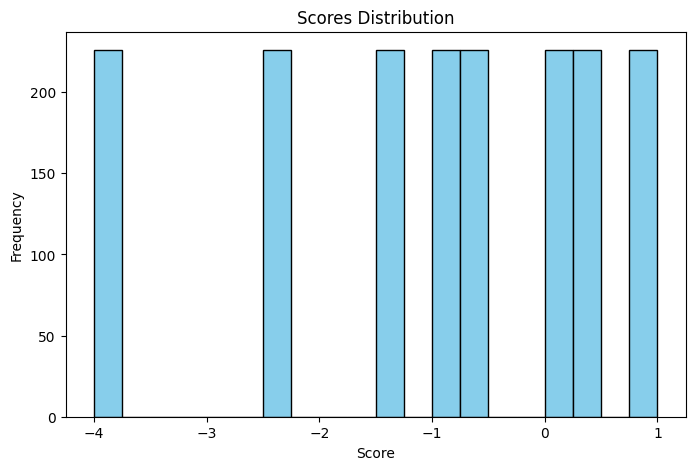

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
# 绘制直方图
plt.figure(figsize=(8, 5))
plt.hist(df_80_filtered['dmos'].values, bins=20, color='skyblue', edgecolor='black')
plt.title('Scores Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

## 只对原始图片进行微调

In [14]:
# 读取每个样品下的all_attention_qingxidu.csv文件，组合成一个大的csv文件
import pandas as pd
import os

demo_list = ['LG', 'SONY', 'AMAZON']
all_df = pd.DataFrame()

for demo in demo_list:
    df = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/{demo}/all_attention_qingxidu.csv")
    all_df = pd.concat([all_df, df], ignore_index=True)

# all_df.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/all_finetune_data_qingxidu_org.csv", index=False)

# 将all_df随机划分为6:2:2分别为训练集、验证集和测试集
df_train = all_df.sample(frac=0.6, random_state=1)
df_wo_train = all_df.drop(df_train.index)
df_val = df_wo_train.sample(frac=0.5, random_state=1)
df_test = df_wo_train.drop(df_val.index)

# 保存df_train, df_val, df_test到csv文件中
# df_train.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/train_finetune_data_org_qingxidu.csv", index=False)
# df_val.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/val_finetune_data_org_qingxidu.csv", index=False)
# df_test.to_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/test_finetune_data_org_qingxidu.csv", index=False)

In [3]:
import numpy as np
from PIL import Image
import pandas as pd

from siamese import Siamese

if __name__ == "__main__":
    model = Siamese()
    # model.eval()
    # 读取测试集
    df = pd.read_csv("/home/hechunjiang/gradio/GeoFormer/finetune_data/all_test_finetune_data_new.csv")
    scores = []
    scores_gt = []
    for i in range(df.shape[0]):
        image_1 = Image.open(df['dist_img'][i])
        image_2 = Image.open(df['ref_img'][i])
        score = model.detect_image(image_1, image_2).to("cpu").numpy()
        scores.append(score[0])
        scores_gt.append(df['dmos'][i])
    print(scores)
    print(scores_gt)

Loading weights into state dict...


/home/hechunjiang/gradio/Siamese-pytorch/siamese.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_path, map_location=device))

/home/hechunjiang/gradio/Siamese-pytorch/logs-finetune-4-qingxidu/best_epoch_weights.pth model loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path | /home/hechunjiang/gradio/Siamese-pytorch/logs-finetune-4-qingxidu/best_epoch_weights.pth|
|              input_shape |                               [256, 256]|
|          letterbox_image |                                    False|
|                     cuda |                                     True|
----------------------------------------------------------------------
[np.float32(-0.26639706), np.float32(-0.2587586), np.float32(-0.4673697), np.float32(-0.38119942), np.float32(-0.7905629), np.float32(0.15851623), np.float32(-0.42801708), np.float32(-0.5674718), np.float32(-0.6692645), np.float32(-0.36635688), np.float32(-0.270472

In [4]:
scores = np.array(scores)
scores_gt = np.array(scores_gt)
# 计算两者的mse loss
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()
loss = criterion(torch.tensor(scores), torch.tensor(scores_gt))
print(loss)

tensor(0.5995, dtype=torch.float64)


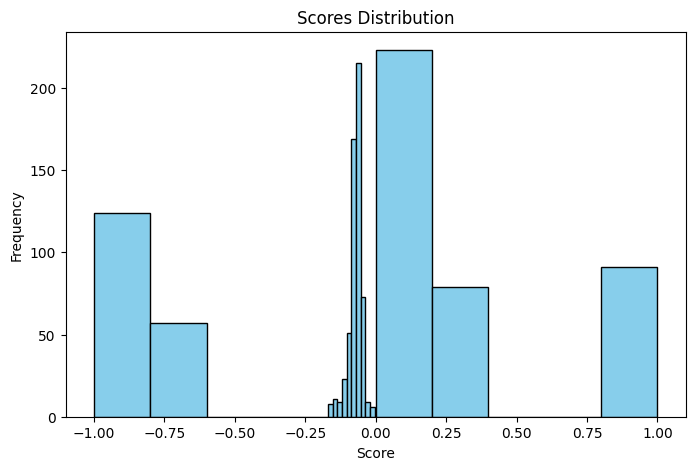

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
# 绘制直方图
plt.figure(figsize=(8, 5))
plt.hist(scores_gt, bins=10, color='skyblue', edgecolor='black')
plt.hist(scores, bins=10, color='skyblue', edgecolor='black')
plt.title('Scores Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# 处理其他指标

## 白平衡

### 调整RGB通道

In [ ]:
from PIL import Image, ImageEnhance


def adjust_white_balance_pillow(image_path, r_factor=1.0, g_factor=1.0, b_factor=1.0):
    image = Image.open(image_path)
    r, g, b = image.split()

    # 调整 RGB 通道
    r = r.point(lambda i: i * r_factor)
    g = g.point(lambda i: i * g_factor)
    b = b.point(lambda i: i * b_factor)

    # 合并通道
    balanced_image = Image.merge('RGB', (r, g, b))
    return balanced_image

# 调整白平衡
image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/4.jpg"
# display(Image.open(image_path))
balanced_image = adjust_white_balance_pillow(image_path, r_factor=0.85, g_factor=1.0, b_factor=1.0)
display(balanced_image)
# balanced_image.save('balanced_image_pillow.jpg')


### 调整色坐标(调整图像色温)

In [ ]:
import cv2
import numpy as np

def adjust_color_temperature(image, temperature):
    """
    调整图像色温
    :param image: 输入图像 (BGR)
    :param temperature: 色温变化值 (正值提高冷色，负值增强暖色)
    :return: 调整后的图像
    """
    # 定义色温转换矩阵，正值偏蓝，负值偏红
    if temperature > 0:
        increase_matrix = np.array([1 - temperature / 100, 1 + temperature / 200, 1 + temperature / 100], dtype=float)
    else:
        increase_matrix = np.array([1 + abs(temperature) / 100, 1, 1 - abs(temperature) / 100], dtype=float)

    # 分别调整 BGR 通道
    b, g, r = cv2.split(image)
    b = np.clip(b * increase_matrix[0], 0, 255).astype(np.uint8)
    g = np.clip(g * increase_matrix[1], 0, 255).astype(np.uint8)
    r = np.clip(r * increase_matrix[2], 0, 255).astype(np.uint8)

    return cv2.merge([b, g, r])

# 示例
image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/4.jpg"
image = cv2.imread(image_path)

# 提高冷色调（增加色温）
# cold_image = adjust_color_temperature(image, temperature=15)

# 增加暖色调（降低色温）
warm_image = adjust_color_temperature(image, temperature=-10)
warm_image1 = adjust_color_temperature(image, temperature=-15)
warm_image2 = adjust_color_temperature(image, temperature=-20)

# cv2.imshow('Original', image)
# cv2.imshow('Cold White Balance', cold_image)
# cv2.imshow('Warm White Balance', warm_image)
# display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(cold_image, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(warm_image, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(warm_image1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(warm_image2, cv2.COLOR_BGR2RGB)))

### 灰阶

#### 使用 OpenCV 调整灰阶
直接通过公式调整灰度值：
new_pixel=α⋅old_pixel+β

α：对比度控制（大于 1 增强，小于 1 减弱）
β：亮度调整（正值提高，负值降低）

In [ ]:
import cv2

img_path = "/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/样品1采集图像/7.jpg"
image = cv2.imread(img_path)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
adjusted_v = cv2.convertScaleAbs(v, alpha=2.5, beta=0)
hsv_adjusted = cv2.merge([h, s, adjusted_v])
# 转换回 RGB 空间
adjusted_image = cv2.cvtColor(hsv_adjusted, cv2.COLOR_HSV2RGB)
pilimg = Image.fromarray(adjusted_image)
display(pilimg)

## 调整彩色饱和度

### 使用ImageEnhance.Color调整彩色饱和度

In [ ]:
from PIL import Image, ImageEnhance

# 打开图像
image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/10.jpg"
image = Image.open(image_path)

# 调整饱和度
enhancer = ImageEnhance.Color(image)

# display(image)

# 增强饱和度
# saturation_increased = enhancer.enhance(1.5)  # 参数 > 1 增强饱和度
# display(saturation_increased)

# 降低饱和度
saturation_decreased = enhancer.enhance(0.75)  # 参数 < 1 减弱饱和度
display(saturation_decreased)
saturation_decreased = enhancer.enhance(0.5)  # 参数 < 1 减弱饱和度
display(saturation_decreased)
saturation_decreased = enhancer.enhance(0.25)  # 参数 < 1 减弱饱和度
display(saturation_decreased)


### 直接操作HSV的饱和度通道

In [ ]:
import cv2
import numpy as np

def adjust_saturation(image, scale=1.0):
    """
    调整图像的饱和度
    :param image: 输入图像（BGR 格式）
    :param scale: 饱和度调整比例（>1 增强饱和度，<1 减弱饱和度）
    :return: 调整后的图像
    """
    # 转换为 HSV 色彩空间
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # 调整饱和度（值范围需限制在 0-255）
    s = np.clip(s * scale, 0, 255).astype(np.uint8)
    
    # 合并调整后的通道并转换回 BGR
    hsv_adjusted = cv2.merge([h, s, v])
    result = cv2.cvtColor(hsv_adjusted, cv2.COLOR_HSV2BGR)
    return result

# 读取图像
image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/10.jpg"
image = cv2.imread(image_path)

# 增强饱和度
# saturation_increased = adjust_saturation(image, scale=1.5)

# 降低饱和度
saturation_decreased = adjust_saturation(image, scale=0.75)
saturation_decreased1 = adjust_saturation(image, scale=0.5)
saturation_decreased2 = adjust_saturation(image, scale=0.25)

# 展示结果
# display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(saturation_increased, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(saturation_decreased, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(saturation_decreased1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(saturation_decreased2, cv2.COLOR_BGR2RGB)))


## 调整色彩准确性

### 法一：使用Gamma校正

In [ ]:
def adjust_gamma(image, gamma=1.0):
    """
    调整图像的 Gamma 值
    :param image: 输入图像
    :param gamma: Gamma 值（<1 增亮，>1 减亮）
    :return: 调整后的图像
    """
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype(np.uint8)
    return cv2.LUT(image, table)

image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/13.jpg"
image = cv2.imread(image_path)

# 增强色彩准确性
# gamma_corrected = adjust_gamma(image, gamma=0.8)  # 提高

# 降低色彩准确性
gamma_reduced = adjust_gamma(image, gamma=1.25)  # 降低
gamma_reduced1 = adjust_gamma(image, gamma=1.5)  # 降低
gamma_reduced2 = adjust_gamma(image, gamma=1.75)  # 降低

# display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(gamma_corrected, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(gamma_reduced, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(gamma_reduced1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(gamma_reduced2, cv2.COLOR_BGR2RGB)))


### 法二：使用ImageEnhance.Color

In [ ]:
from PIL import Image, ImageEnhance

# 打开图像
image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/13.jpg"
image = Image.open(image_path)

# 提高色彩准确性
enhancer = ImageEnhance.Color(image)
image_color_enhanced = enhancer.enhance(1.5)  # 提高色彩表现
image_color_enhanced1 = enhancer.enhance(2.5)  # 提高色彩表现
image_color_enhanced2 = enhancer.enhance(3.5)  # 提高色彩表现
# image_color_reduced = enhancer.enhance(0.75)
# image_color_reduced1 = enhancer.enhance(0.5)
# image_color_reduced2 = enhancer.enhance(0.25)

# display(image_color_reduced)
# display(image_color_reduced1)
# display(image_color_reduced2)
display(image_color_enhanced)
display(image_color_enhanced1)
display(image_color_enhanced2)
# display(image_color_reduced)

### 法三：调整H通道

In [ ]:
import cv2
import numpy as np

def adjust_hue(image_path, hue_offset):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h = h.astype(np.int16)
    h = (h + hue_offset) % 180
    h = h.astype(np.uint8)
    hsv = cv2.merge([h, s, v])
    result = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return result


image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/13.jpg"
adjusted = adjust_hue(image_path, -10)
adjusted1 = adjust_hue(image_path, -15)
adjusted2 = adjust_hue(image_path, -20)

display(Image.fromarray(cv2.cvtColor(adjusted, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(adjusted1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(adjusted2, cv2.COLOR_BGR2RGB)))

## 对比度

### 法一：线性变换

In [ ]:
import cv2
import numpy as np


def adjust_contrast(image, alpha, beta=0):
    """
    调整图像的对比度和亮度
    :param image: 输入图像
    :param alpha: 对比度因子（>1 提高，<1 降低）
    :param beta: 亮度增量（默认 0）
    :return: 调整后的图像
    """
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted


# 加载图像
image_path = "/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/样品1采集图像/16.jpg"
image = cv2.imread(image_path)

# 提高对比度
high_contrast = adjust_contrast(image, alpha=1.3)
high_contrast1 = adjust_contrast(image, alpha=1.6)
high_contrast2 = adjust_contrast(image, alpha=1.9)

# 降低对比度
# low_contrast = adjust_contrast(image, alpha=0.9)
# low_contrast1 = adjust_contrast(image, alpha=0.7)
# low_contrast2 = adjust_contrast(image, alpha=0.5)

# 显示结果
# display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(high_contrast, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(low_contrast, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(low_contrast1, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(low_contrast2, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(high_contrast, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(high_contrast1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(high_contrast2, cv2.COLOR_BGR2RGB)))

### 法二：ImageEnhance.Contrast调整对比度

In [ ]:
from PIL import Image, ImageEnhance

# 加载图像
image_path = "/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/样品1采集图像/16.jpg"
# image_path = "/home/hechunjiang/gradio/样品2 SONY 43吋/华为P50手机采集图像/16.jpg"
image = Image.open(image_path)

# 提高对比度
enhancer = ImageEnhance.Contrast(image)
high_contrast = enhancer.enhance(1.2)  # 提高对比度
high_contrast1 = enhancer.enhance(1.7)  # 提高对比度
high_contrast2 = enhancer.enhance(2.2)  # 提高对比度
# low_contrast = enhancer.enhance(0.9)  # 降低对比度
# low_contrast1 = enhancer.enhance(0.7)  # 降低对比度
# low_contrast2 = enhancer.enhance(0.5)  # 降低对比度

# display(image)
display(high_contrast)
display(high_contrast1)
display(high_contrast2)
# display(low_contrast)
# display(low_contrast1)
# display(low_contrast2)


## 区域控光

### 方法一：改变全局亮度

In [ ]:
import cv2
import numpy as np

def change_brightness(image, brightness=50):
    """
    改变整张图像的亮度
    :param image: 输入图像
    :param brightness: 调整亮度的值（正值增加亮度，负值降低亮度）
    :return: 调整后的图像
    """
    return cv2.convertScaleAbs(image, alpha=1, beta=brightness)

# 加载图像
image_path = "/home/hechunjiang/gradio/样品3 亚马逊 43吋/华为P50手机采集图像/20.jpg"
image = cv2.imread(image_path)

# 调整亮度
brighter_image = change_brightness(image, brightness=15)
brighter_image1 = change_brightness(image, brightness=25)
brighter_image2 = change_brightness(image, brightness=35)
# darker_image = change_brightness(image, brightness=-50)

# 显示结果
# display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(brighter_image, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(brighter_image1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(brighter_image2, cv2.COLOR_BGR2RGB)))
# display(Image.fromarray(cv2.cvtColor(darker_image, cv2.COLOR_BGR2RGB)))


In [5]:
import numpy as np
import pandas as pd
from utils.utils import pltHistogram

index_list = ["qingxidu",
              "baipingheng",
              "huijie",
              "caisebaohedu",
              "caisezhunquexing",
              "duibidu",
              "quyukongguang"]

for index in index_list:
    df = pd.read_csv(
        f"/home/hechunjiang/gradio/GeoFormer/finetune_data/final_train_finetune_data_{index}_all.csv")
    df2 = pd.read_csv(
        f"/home/hechunjiang/gradio/GeoFormer/finetune_data/final_train_finetune_data_{index}.csv")
    print(df.shape, df2.shape)

(4093, 3) (3455, 3)
(2784, 3) (1848, 3)
(1373, 3) (1115, 3)
(2158, 3) (1056, 3)
(5577, 3) (4117, 3)
(4305, 3) (3420, 3)
(699, 3) (579, 3)


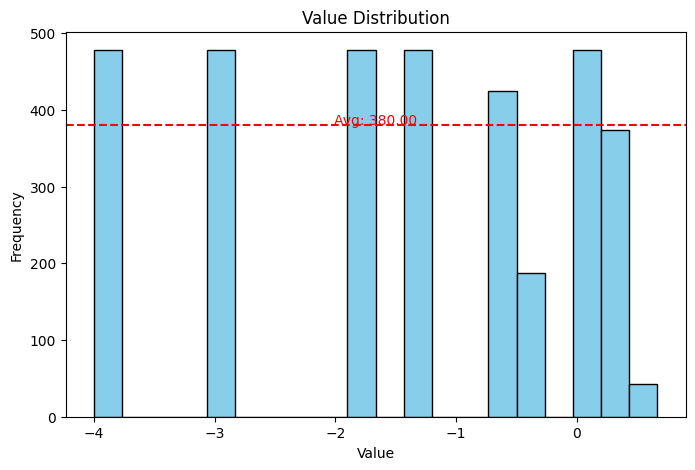

(3420, 3)


In [46]:
import numpy as np
import pandas as pd
from utils.utils import pltHistogram

index_list = ["qingxidu",
              "baipingheng",
              "huijie",
              "caisebaohedu",
              "caisezhunquexing",
              "duibidu",
              "quyukongguang"]

index = "duibidu"

df = pd.read_csv(
    f"/home/hechunjiang/gradio/GeoFormer/finetune_data/final_train_finetune_data_{index}.csv")
pltHistogram(df['dmos'].values)
print(df.shape)


In [4]:
grouped = df.groupby('dmos')
sum = 0
for name, group in grouped:
    if len(group) > 152:
        sum += 152
    else:
        sum += len(group)
sum

1115

# 画最后的训练图

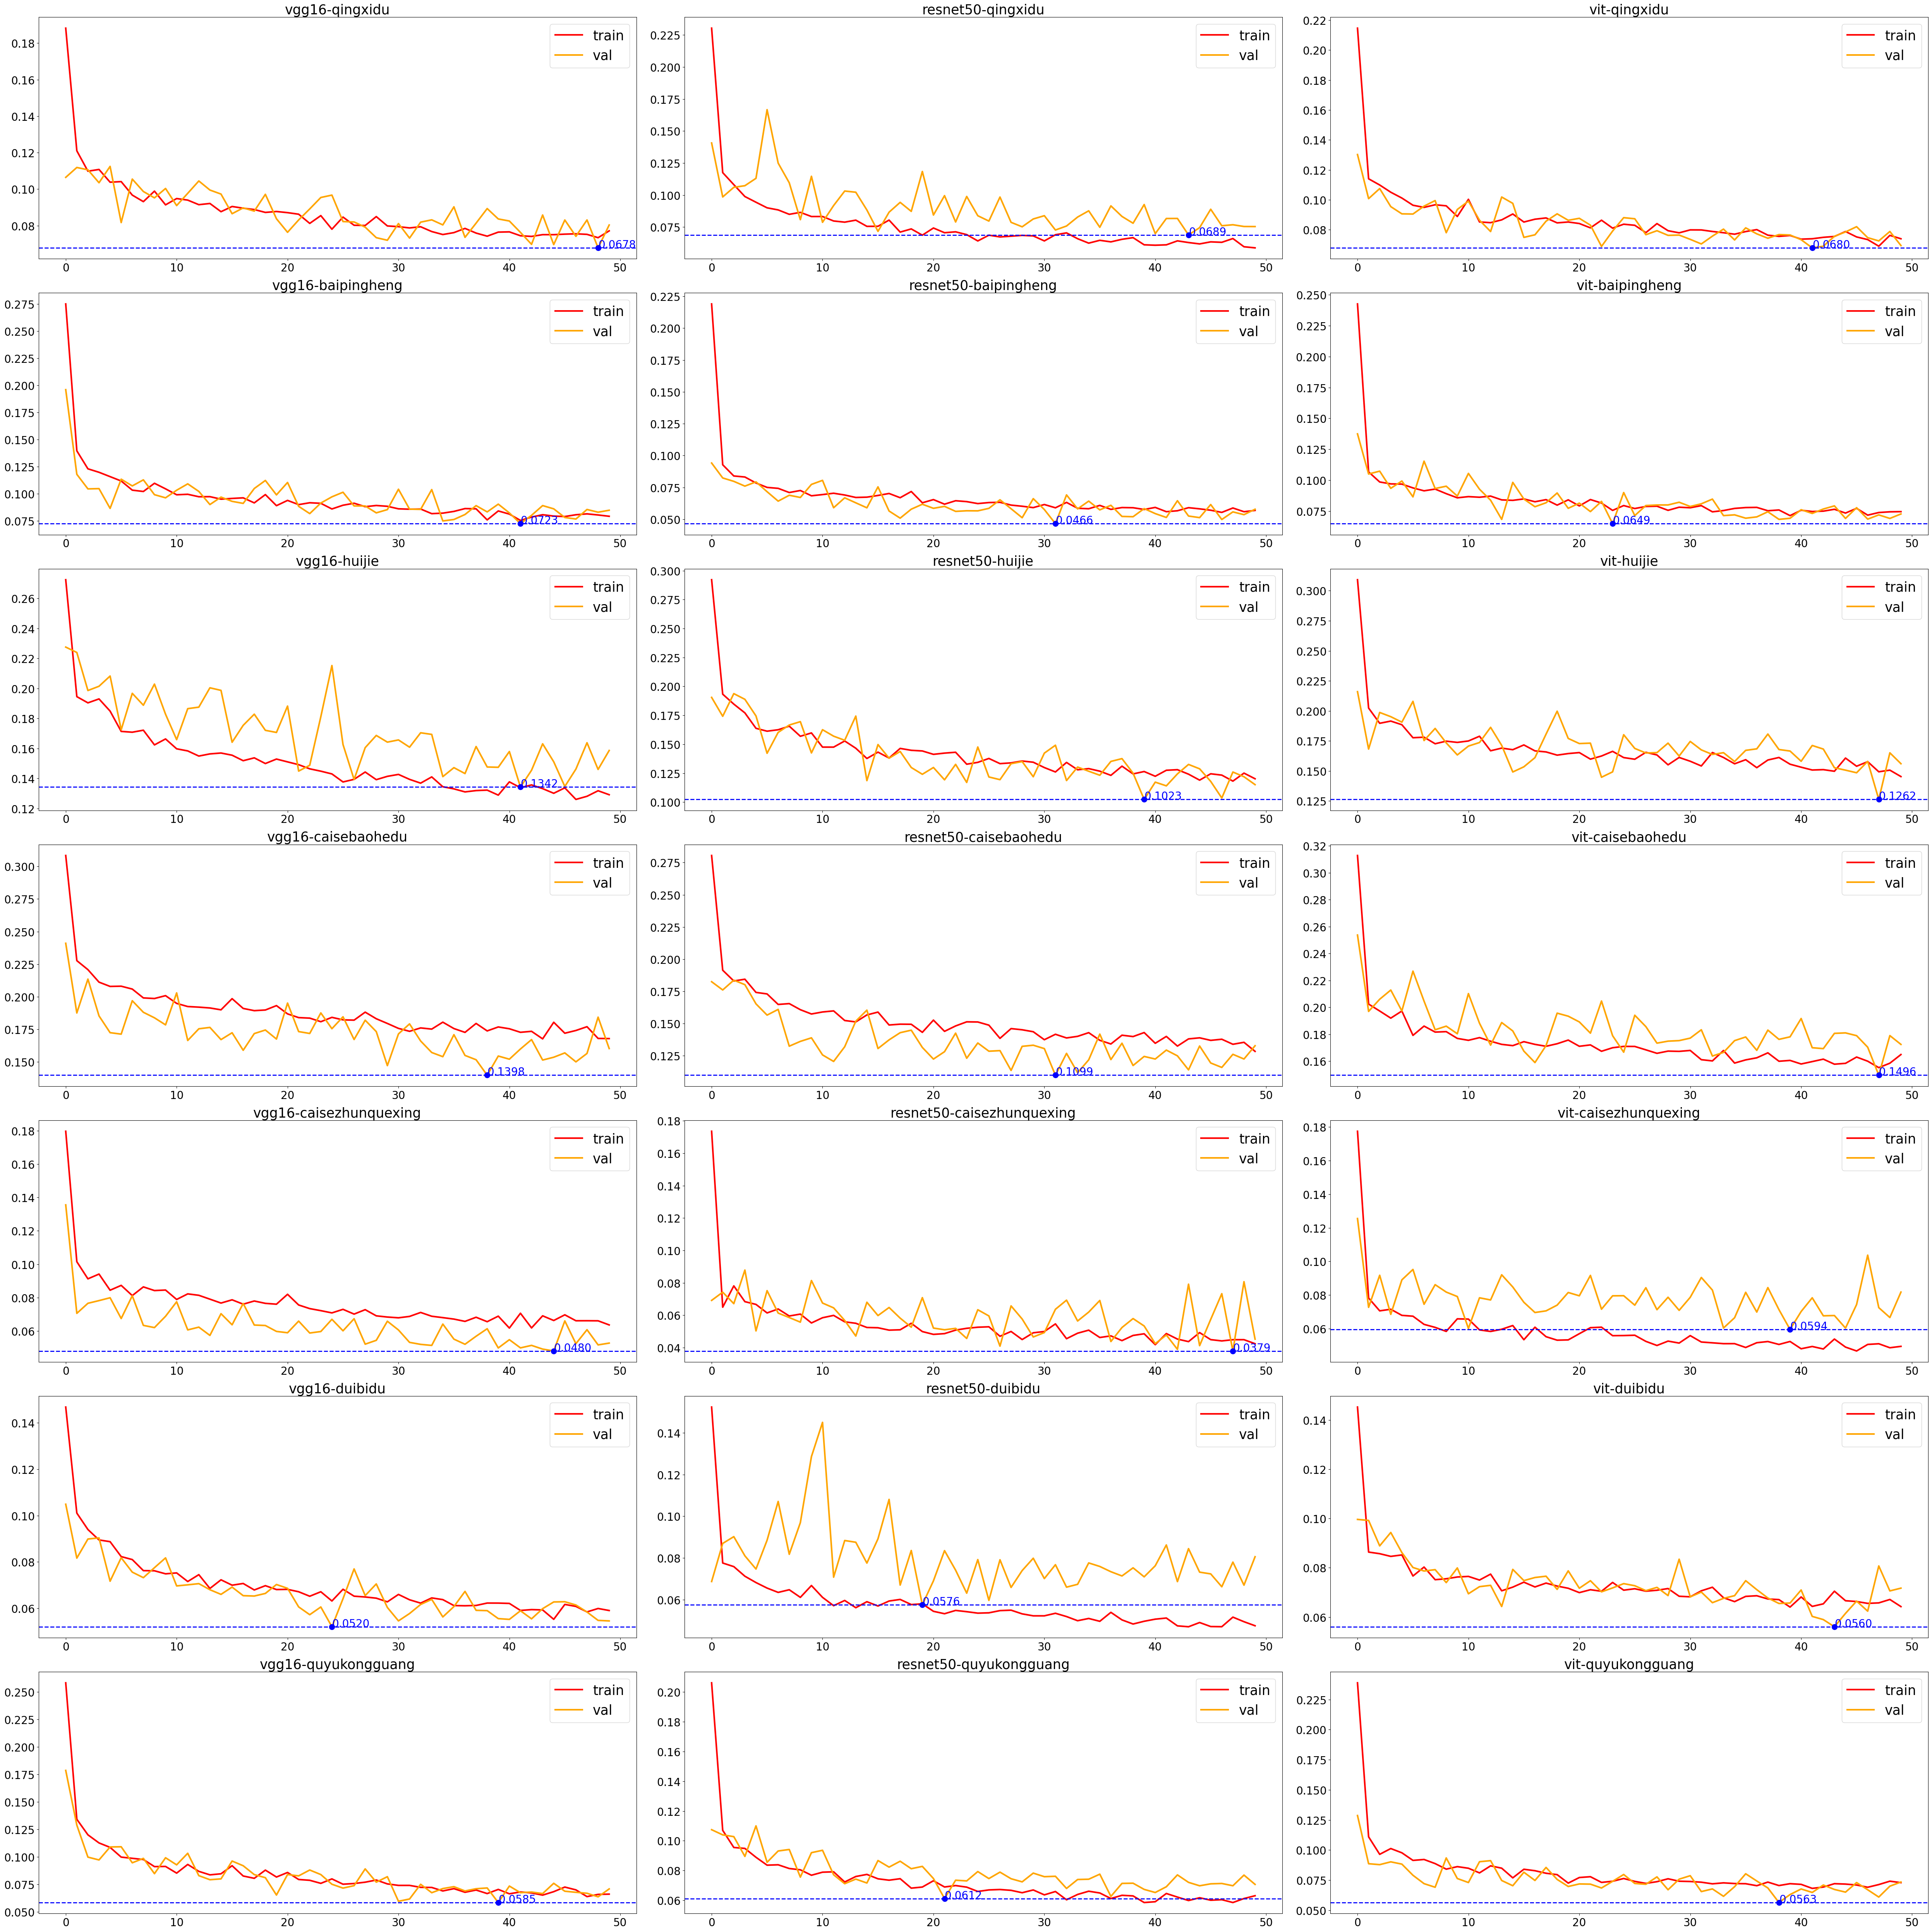

In [4]:
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
import numpy as np

# 构建完整路径列表
logs_path = "/home/hechunjiang/gradio/Siamese-pytorch/logs/"
demo_list = os.listdir(logs_path)
demo_list = [x for x in demo_list if os.path.isdir(os.path.join(logs_path, x))]
demo_list.sort()

demo_list = demo_list[-21:]
date_list = ["loss_" + x.split('-')[0] for x in demo_list]

date_list = date_list[-21:]

# 创建完整路径列表
full_paths = [os.path.join(logs_path, demo, date) for demo, date in zip(demo_list, date_list)]

def combine_images_compact(full_paths):
    n_images = len(full_paths)
    n_cols = 3  # 列数
    n_rows = 7  # 行数
    
    # 创建更紧凑的图形
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 50))
    
    # 设置子图之间的间距
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    # 确保axes是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 填充图片
    for idx, path in enumerate(full_paths):
        row = idx // n_cols
        col = idx % n_cols
        
        # 读取epoch_loss.txt和epoch_loss_val.txt文件，绘制图像
        loss_path = os.path.join(path, 'epoch_loss.txt')
        loss_val_path = os.path.join(path, 'epoch_val_loss.txt')
        if not os.path.exists(loss_path) or not os.path.exists(loss_val_path):
            print(f"not found: {loss_path} or {loss_val_path}")
            continue

        # 读取数据
        with open(loss_path, 'r') as f:
            loss_data = f.readlines()
            loss_data = [float(x.strip()) for x in loss_data]
        with open(loss_val_path, 'r') as f:
            loss_val_data = f.readlines()
            loss_val_data = [float(x.strip()) for x in loss_val_data]

        # 绘制图像
        axes[row, col].plot(loss_data, label='train', linewidth=3, color='red')
        axes[row, col].plot(loss_val_data, label='val', linewidth=3, color='orange')
        title = "-".join(path.split('/')[-2].split('-')[2:])
        axes[row, col].set_title(title, fontsize=25)
        axes[row, col].legend(fontsize=25, loc='best')
        axes[row, col].tick_params(axis='both', which='major', labelsize=20)

        # 绘制loss_val_data的最小值到图上
        min_loss_val = min(loss_val_data)
        min_loss_val_idx = loss_val_data.index(min_loss_val)
        axes[row, col].plot(min_loss_val_idx, min_loss_val, 'bo', markersize=10)
        axes[row, col].axhline(y=min_loss_val, color='blue', linestyle='--', linewidth=2)
        axes[row, col].annotate(f"{min_loss_val:.4f}", (min_loss_val_idx, min_loss_val), fontsize=20, color='blue')


    # 隐藏多余的子图
    for idx in range(len(full_paths), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
        axes[row, col].set_visible(False)
    
    # 调整整体布局
    plt.tight_layout()
    plt.show()
    plt.close()


combine_images_compact(full_paths)

# 各个指标的特征

## RGB

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_color_histogram(image_path, bins=8):
    # 加载图像并转换为RGB格式
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 计算每个通道的颜色直方图
    hist_r = cv2.calcHist([image_rgb], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([image_rgb], [1], None, [bins], [0, 256])
    hist_b = cv2.calcHist([image_rgb], [2], None, [bins], [0, 256])

    # 将三个直方图拼接成一个特征向量
    color_hist_feature = np.concatenate((hist_r.flatten(), hist_g.flatten(), hist_b.flatten()))

    plt.figure()
    plt.title("Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    
    colors = ('r', 'g', 'b')
    for i, col in enumerate(colors):
        histr = cv2.calcHist([image_rgb], [i], None, [bins], [0, 256])
        plt.plot(histr, color=col)
        plt.xlim([0, bins])
    
    plt.show()

    return color_hist_feature

# 使用函数
histogram_feature = calculate_color_histogram('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg', bins=16)
print("Histogram feature vector:", histogram_feature)

## HSV

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_hsv_histogram(image_path, bins=8):
    # 加载图像并转换为HSV格式
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return
    
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 计算每个通道的颜色直方图
    hist_h = cv2.calcHist([image_hsv], [0], None, [bins], [0, 180])  # H通道范围是[0, 180]
    hist_s = cv2.calcHist([image_hsv], [1], None, [bins], [0, 256])  # S通道范围是[0, 256]
    hist_v = cv2.calcHist([image_hsv], [2], None, [bins], [0, 256])  # V通道范围是[0, 256]

    # 将三个直方图拼接成一个特征向量
    hsv_hist_feature = np.concatenate((hist_h.flatten(), hist_s.flatten(), hist_v.flatten()))

    # 可视化直方图（可选）
    plt.figure()
    plt.title("HSV Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")

    colors = ('r', 'g', 'b')
    channel_names = ('Hue', 'Saturation', 'Value')
    for i, col in enumerate(colors):
        histr = cv2.calcHist([image_hsv], [i], None, [bins], [0, 180 if i == 0 else 256])
        plt.plot(histr, color=col, label=channel_names[i])
        plt.xlim([0, bins])
    
    plt.legend()
    plt.show()

    return hsv_hist_feature

# 使用函数
histogram_feature = calculate_hsv_histogram('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg', bins=16)
print("HSV Histogram feature vector:", histogram_feature)

## 灰度值

In [ ]:
def calculate_grayscale_histogram(image_path, bins=256):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return
    
    # 计算灰度直方图
    hist_gray = cv2.calcHist([image], [0], None, [bins], [0, 256])

    # # 将直方图归一化（可选）
    # hist_gray_normalized = cv2.normalize(hist_gray, hist_gray).flatten()

    # 可视化直方图（可选）
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(hist_gray, color='gray')
    plt.xlim([0, bins])
    plt.show()

    return hist_gray

# 使用函数
histogram_feature = calculate_grayscale_histogram('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg', bins=16)
print("Grayscale histogram feature vector:", histogram_feature)

## 颜色矩

In [8]:
import cv2
import numpy as np

def calculate_color_moments(image_path):
    # 加载图像并转换为RGB格式
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 初始化一个列表用于存储所有颜色通道的颜色矩
    color_moments = []

    # 分别对R, G, B三个通道进行计算
    for channel_id in range(3):
        channel = image_rgb[:, :, channel_id]

        # 计算均值（Mean）
        mean = np.mean(channel)

        # 计算标准差（Standard Deviation）
        std_dev = np.std(channel)

        # 计算偏度（Skewness），需要先减去均值再除以标准差
        skewness = np.mean(((channel - mean) / std_dev) ** 3) if std_dev != 0 else 0

        # 将当前通道的颜色矩添加到列表中
        color_moments.extend([mean, std_dev, skewness])

    # 返回颜色矩作为一个特征向量
    return np.array(color_moments)

# 使用函数
color_moments_features = calculate_color_moments('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg')
print("Color Moments (均值, 方差, 偏度 for R, G, B):", color_moments_features)

Color Moments (均值, 方差, 偏度 for R, G, B): [111.91242994  74.22447259   0.31490324  84.86592786  60.62705263
   0.58499027  94.25371499  55.25499225   0.67014763]


## GLCM

In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt


def calculate_glcm_features(image_path, distances=[1], angles=[0], levels=256, props=['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return

    # 计算灰度共生矩阵
    glcm = graycomatrix(image, distances=distances, angles=angles,
                        levels=levels, symmetric=True, normed=True)

    # 提取指定属性的特征值
    features = []
    for prop in props:
        feature = graycoprops(glcm, prop)
        features.append(feature.flatten())

    # 将所有特征合并成一个特征向量
    glcm_features = np.concatenate(features)

    # 可视化灰度图像（可选）
    plt.figure()
    plt.title("Grayscale Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    # 返回GLCM特征向量
    return glcm_features


# 使用函数
glcm_features = calculate_glcm_features(
    '/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg', distances=[1, 2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])
print("GLCM Features:", glcm_features)

## LBP

In [ ]:
import cv2
import numpy as np
from skimage import feature
import matplotlib.pyplot as plt

def calculate_lbp_features(image_path, P=8, R=1, method='uniform'):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return
    
    # 计算LBP特征
    lbp = feature.local_binary_pattern(image, P, R, method)

    # 计算LBP直方图
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))

    # 归一化直方图
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # 避免除以零

    # 可视化LBP图像（可选）
    plt.figure()
    plt.title("LBP Image")
    plt.imshow(lbp, cmap='gray')
    plt.axis('off')
    plt.show()

    # 可视化LBP直方图（可选）
    plt.figure()
    plt.title("LBP Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(hist)
    plt.xlim([0, len(hist)])
    plt.show()

    # 返回LBP直方图作为一个特征向量
    return hist

# 使用函数
lbp_features = calculate_lbp_features('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg', P=8, R=1, method='uniform')
print("LBP Features:", lbp_features)

## 小波变换

In [ ]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

def calculate_wavelet_features(image_path, wavelet='db1', level=1):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return
    
    # 对图像进行小波变换
    coeffs = pywt.wavedec2(image, wavelet, level=level)

    # 提取近似系数和其他细节系数
    approx_coeffs = coeffs[0]
    detail_coeffs = coeffs[1:]

    # 将所有系数展平成一维数组
    all_coeffs = [approx_coeffs.flatten()]
    for d in detail_coeffs:
        for band in d:
            all_coeffs.append(band.flatten())

    # 将所有系数合并成一个特征向量
    wavelet_features = np.concatenate(all_coeffs)

    # 可视化小波变换结果（可选）
    plt.figure(figsize=(12, 8))
    
    # 显示原始图像
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # 显示近似系数
    plt.subplot(2, 3, 2)
    plt.title("Approximation Coefficients")
    plt.imshow(approx_coeffs, cmap='gray')
    plt.axis('off')

    # 显示水平、垂直和对角细节系数
    detail_bands = ['Horizontal', 'Vertical', 'Diagonal']
    for i, (d, label) in enumerate(zip(detail_coeffs[-1], detail_bands)):
        plt.subplot(2, 3, 3 + i)
        plt.title(f"{label} Detail Coefficients")
        plt.imshow(d, cmap='gray')
        plt.axis('off')

    plt.show()

    # 返回小波变换的特征向量
    return wavelet_features

# 使用函数
wavelet_features = calculate_wavelet_features('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg', wavelet='haar', level=1)
print("Wavelet Features:", wavelet_features)

## Hu

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_hu_moments(image_path):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return
    
    # 应用二值化处理，确保只计算前景对象的Hu矩
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 计算图像矩
    moments = cv2.moments(binary_image)

    # 计算Hu矩
    hu_moments = cv2.HuMoments(moments).flatten()

    # 可视化二值化后的图像（可选）
    plt.figure()
    plt.title("Binary Image")
    plt.imshow(binary_image, cmap='gray')
    plt.axis('off')
    plt.show()

    # 返回Hu矩作为一个特征向量
    return hu_moments

# 使用函数
hu_moments_features = calculate_hu_moments('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg')
print("Hu Moments Features:", hu_moments_features)

## HOG特征

In [7]:
import cv2
import numpy as np


def calculate_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 读取为灰度图像

    if image is None:
        print("Error: Image not found.")
        exit()

    # 调整图像大小（HOG需要统一的图像大小）
    image = cv2.resize(image, (128, 64))  # 常用的HOG输入大小

    # 初始化 HOG 描述符
    win_size = (128, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

    # 计算 HOG 特征
    hog_features = hog.compute(image)

    hog_features_array = hog_features.flatten()

    return hog_features_array

# 加载图像并进行预处理
image_path = '/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg'  # 替换为你的图像路径

hog_features_array = calculate_hog_features(image_path)
print(f"hog features shape: {hog_features_array.shape}, features: {hog_features_array}")

hog features shape: (3780,), features: [0.34486812 0.13285984 0.07301226 ... 0.05142426 0.06784158 0.28086984]


## zernike矩

In [ ]:
import cv2
import numpy as np
import mahotas
import mahotas.features
import matplotlib.pyplot as plt

def calculate_zernike_moments(image_path, radius=64, degree=8):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return
    
    # 应用二值化处理，确保只计算前景对象的Zernike矩
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 查找轮廓并找到最大轮廓（假设是主要对象）
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)

    # 获取最小外接圆以确定中心点和半径
    (center_x, center_y), min_enclosing_radius = cv2.minEnclosingCircle(max_contour)
    center = (int(center_x), int(center_y))
    min_enclosing_radius = int(min_enclosing_radius)

    # 创建掩码并应用到二值化图像上，确保只有感兴趣区域被考虑
    mask = np.zeros_like(binary_image)
    cv2.circle(mask, center, min_enclosing_radius, 255, -1)
    masked_image = cv2.bitwise_and(binary_image, binary_image, mask=mask)

    # 计算Zernike矩
    zernike_moments = mahotas.features.zernike(masked_image, radius=min_enclosing_radius, degree=degree)

    # 可视化二值化后的图像及其掩码（可选）
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Binary Image")
    plt.imshow(binary_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Masked Image with Circle")
    plt.imshow(masked_image, cmap='gray')
    plt.scatter(center_x, center_y, c='red', marker='x')  # 标记中心点
    plt.axis('off')

    plt.show()

    # 返回Zernike矩作为一个特征向量
    return zernike_moments, masked_image

# 使用函数
zernike_features, masked_image = calculate_zernike_moments('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg', radius=64, degree=8)
print("Zernike Moments Features:", zernike_features)

## 边缘

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def canny_edge_detection(image_path, low_threshold=100, high_threshold=200):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return
    
    # 高斯模糊以减少噪声
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Canny 边缘检测
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    # 可视化原始图像和边缘检测结果
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Canny Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

    plt.show()

    # 返回边缘图像
    return edges

# 使用函数
edges = canny_edge_detection('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg')
print("Edges detected.")

# 如果需要将边缘检测结果作为特征向量，可以将边缘图像展平成一维数组
edge_features = edges.flatten()
print("Edge Features:", edge_features)

## SIFT

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_sift_features(image_path):
    # 加载图像并转换为灰度格式
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return
    
    # 初始化SIFT检测器
    sift = cv2.SIFT_create()

    # 检测关键点并计算描述符
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # 可视化关键点（可选）
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Image with SIFT Keypoints")
    plt.imshow(image_with_keypoints)
    plt.axis('off')

    plt.show()

    # 返回SIFT特征向量（描述符）
    return keypoints, descriptors

# 使用函数
keypoints, descriptors = calculate_sift_features('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg')
print("Number of Keypoints Detected:", len(keypoints))
if descriptors is not None:
    print("Descriptors Shape:", descriptors.shape)
else:
    print("No descriptors found.")

Error: Image not found.


[ WARN:0@1.766] global loadsave.cpp:241 findDecoder imread_('/home/hechunjiang/gradio/样品1 LG 65UF8580/华为P50手机采集图像/监视器采集图像/1.jpg'): can't open/read file: check file path/integrity


TypeError: cannot unpack non-iterable NoneType object

4842 4842


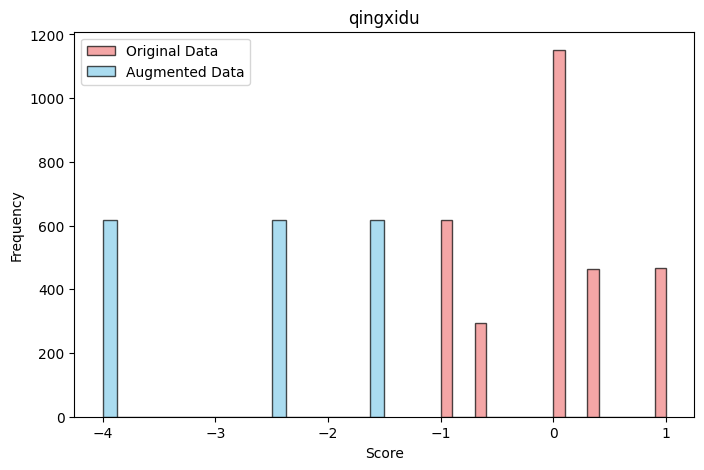

3908 3908


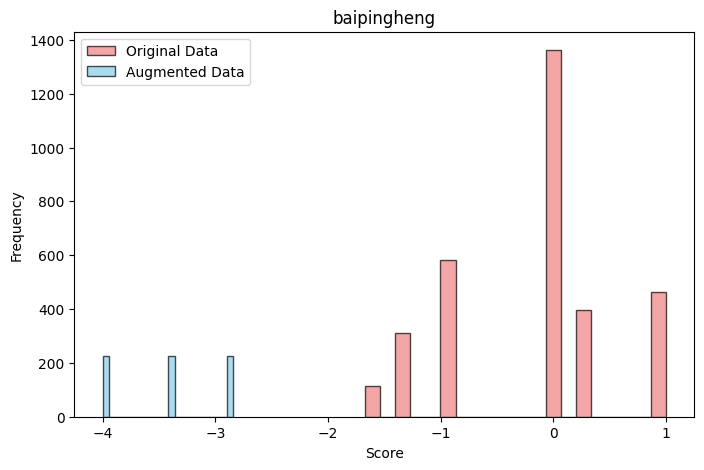

2640 2640


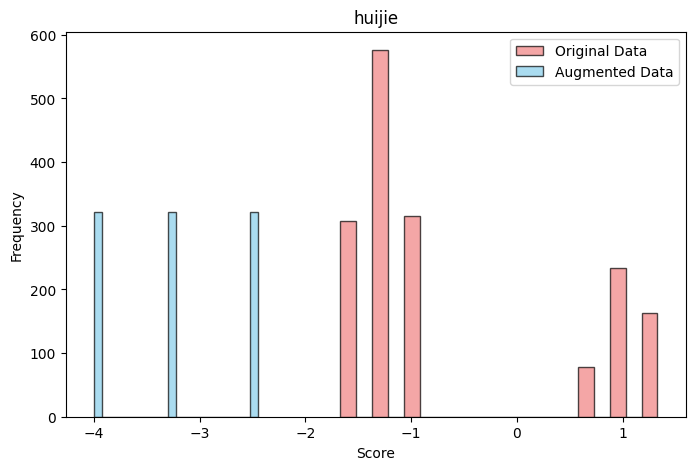

4616 4616


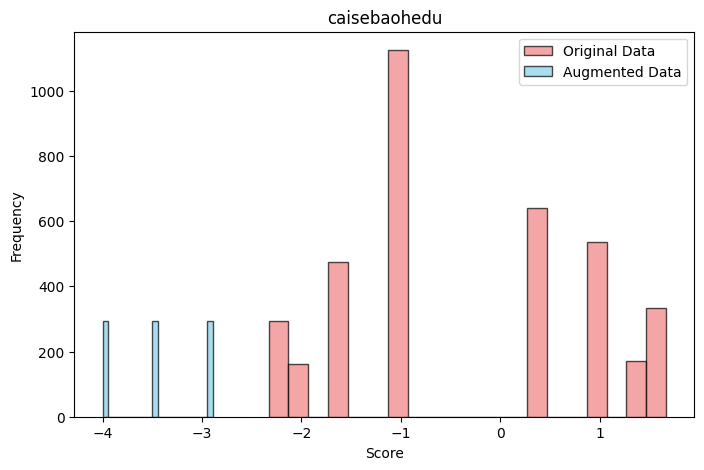

8357 8357


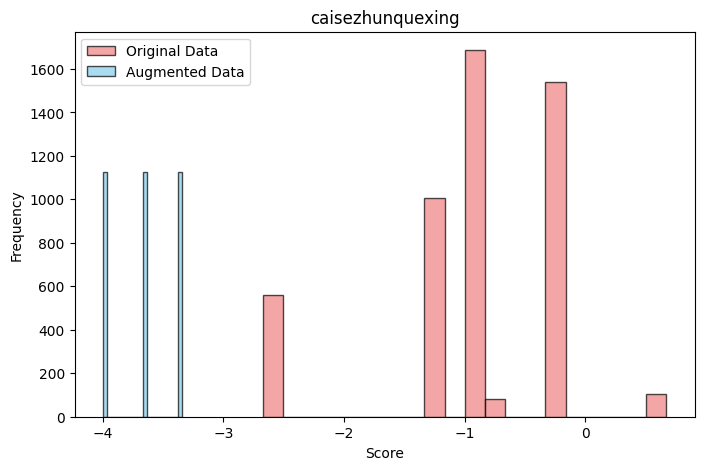

7834 7834


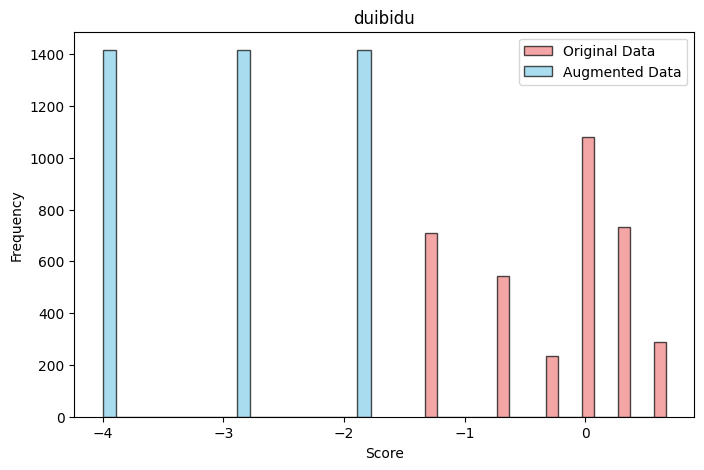

851 851


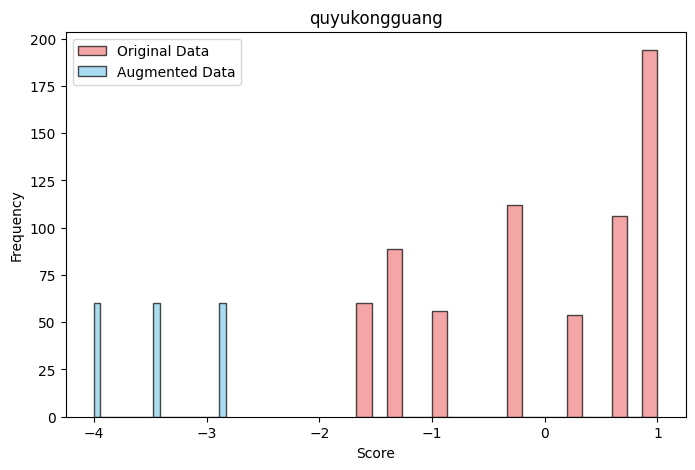

In [28]:
# 原始数据集: "/home/hechunjiang/gradio/GeoFormer/finetune_data/original_data/all_attention_original_data_{index}.csv"
# 扩充数据集: "/home/hechunjiang/gradio/GeoFormer/finetune_data/augment_data/all_attention_augment_data_{index}.csv"
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

index_list = ["qingxidu",
              "baipingheng",
              "huijie",
              "caisebaohedu",
              "caisezhunquexing",
              "duibidu",
              "quyukongguang"]

# 读取数据集
all_df = [pd.DataFrame() for _ in range(len(index_list))]
for idx, index in enumerate(index_list):
    # index = "caisebaohedu"
    df_train = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/original_data/all_attention_original_data_{index}.csv")
    df_aug = pd.read_csv(f"/home/hechunjiang/gradio/GeoFormer/finetune_data/augment_data/all_attention_augment_data_{index}.csv")

    all_df[idx] = pd.concat([df_train, df_aug], ignore_index=True)

    print(len(df_train) + len(df_aug), len(all_df[idx]))
    # print(df_train.shape, df_aug.shape)

    # 绘制直方图
    plt.figure(figsize=(8, 5))
    # 绘制原始数据集的直方图
    plt.hist(df_train['dmos'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7, label='Original Data')
    # 绘制扩充数据集的直方图
    plt.hist(df_aug['dmos'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Augmented Data')
    plt.title(f'{index}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [45]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# 假设我们有七组数据的列表，每组数据是一个DataFrame
group1 = pd.DataFrame({'data': all_df[0]['dmos'].values, 'label': 0})
group2 = pd.DataFrame({'data': all_df[1]['dmos'].values, 'label': 1})
group3 = pd.DataFrame({'data': all_df[2]['dmos'].values, 'label': 2})
group4 = pd.DataFrame({'data': all_df[3]['dmos'].values, 'label': 3})
group5 = pd.DataFrame({'data': all_df[4]['dmos'].values, 'label': 4})
group6 = pd.DataFrame({'data': all_df[5]['dmos'].values, 'label': 5})
group7 = pd.DataFrame({'data': all_df[6]['dmos'].values, 'label': 6})

# 将七组数据放到一个列表中
groups = [group1, group2, group3, group4, group5, group6, group7]

# 1. 统计各组数据的样本数量
group_sizes = [len(g) for g in groups]
print("原始数据组的大小：", group_sizes)

# 2. 确定目标数量（例如，使用中位数）
target_size = int(np.median(group_sizes))
print("目标数量：", target_size)

# 3. 处理各组数据（下采样和上采样）
balanced_groups = []

for i, group in enumerate(groups):
    if len(group) > target_size:
        # 下采样：随机选择目标数量的数据
        downsampled = resample(group, 
                               replace=False,  # 不放回采样
                               n_samples=target_size, 
                               random_state=42)
        balanced_groups.append(downsampled)
        print(f"组 {i} 下采样到 {len(downsampled)}")
    elif len(group) < target_size:
        # 上采样：随机复制数据直到达到目标数量
        upsampled = resample(group, 
                             replace=True,  # 放回采样
                             n_samples=target_size, 
                             random_state=42)
        balanced_groups.append(upsampled)
        print(f"组 {i} 上采样到 {len(upsampled)}")
    else:
        # 如果数据量刚好等于目标数量，不做处理
        balanced_groups.append(group)
        print(f"组 {i} 保持原样，数量为 {len(group)}")

# 4. 合并所有处理后的数据
balanced_data = pd.concat(balanced_groups, axis=0)
print("处理后的数据大小：", len(balanced_data))

# 检查各标签的数量分布
print("最终各组数据的数量：")
print(balanced_data['label'].value_counts())


原始数据组的大小： [4842, 3908, 2640, 4616, 8357, 7834, 851]
目标数量： 4616
组 0 下采样到 4616
组 1 上采样到 4616
组 2 上采样到 4616
组 3 保持原样，数量为 4616
组 4 下采样到 4616
组 5 下采样到 4616
组 6 上采样到 4616
处理后的数据大小： 32312
最终各组数据的数量：
label
0    4616
1    4616
2    4616
3    4616
4    4616
5    4616
6    4616
Name: count, dtype: int64


In [29]:
from sklearn.utils import resample

balanced = None
target_size = 3000
if len(all_df[0]) > target_size:
    # 下采样：随机选择目标数量的数据
    downsampled = resample(all_df[0], 
                           replace=False,  # 不放回采样
                           n_samples=target_size, 
                           random_state=42)
    balanced = downsampled
    print(f"下采样到 {len(downsampled)}")
elif len(all_df[0]) < target_size:
    # 上采样：随机复制数据直到达到目标数量
    upsampled = resample(all_df[0], 
                         replace=True,  # 放回采样
                         n_samples=target_size, 
                         random_state=42)
    balanced = upsampled
    print(f"上采样到 {len(upsampled)}")
else:
    # 如果数据量刚好等于目标数量，不做处理
    balanced = upsampled
    print(f"保持原样，数量为 {len(group)}")

下采样到 3000


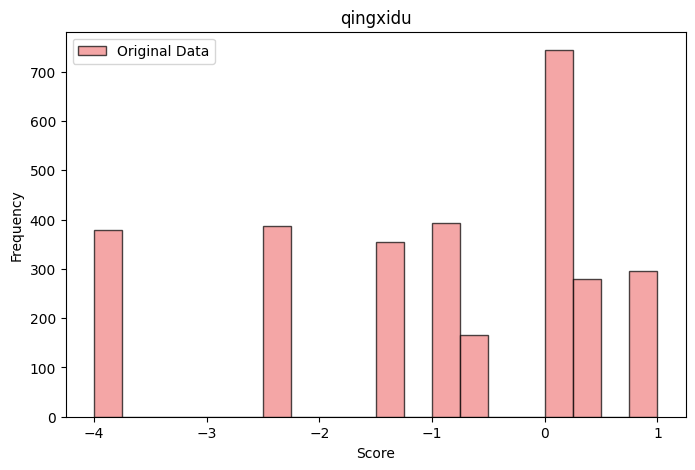

In [31]:
# 绘制直方图
plt.figure(figsize=(8, 5))
# 绘制原始数据集的直方图
plt.hist(balanced['dmos'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7, label='Original Data')
# 绘制扩充数据集的直方图
# plt.hist(df_aug['dmos'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Augmented Data')
plt.title(f'{index_list[0]}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [2]:
import os

path = "/home/hechunjiang/gradio/Siamese-pytorch/logs"

# 获取所有文件夹
demo_list = os.listdir(path)

# 删除所有文件夹下ep开头的文件
for demo in demo_list:
    if not os.path.isdir(os.path.join(path, demo)):
        continue
    files = os.listdir(os.path.join(path, demo))
    for file in files:
        if file.startswith("ep"):
            os.remove(os.path.join(path, demo, file))

# final_out转以demo单独文件的形式

In [4]:
import pandas as pd
import os

# 假设文件路径为file1.txt, file2.txt, file3.txt
input_files = ["/home/hechunjiang/gradio/Siamese-pytorch/final_output_tanh-vgg16/final_output.csv",
               "/home/hechunjiang/gradio/Siamese-pytorch/final_output_tanh-resnet50/final_output.csv",
               "/home/hechunjiang/gradio/Siamese-pytorch/final_output_tanh-vit/final_output.csv"]
output_dir = "output_files_allmodel"
os.makedirs(output_dir, exist_ok=True)

# 读取所有文件并存储为DataFrame列表
dataframes = []
for file in input_files:
    df = pd.read_csv(file, header=0)
    dataframes.append(df)

# 提取每个demo的数据并写入单独的文件
headers = dataframes[0].columns
for demo in headers:
    demo_data = pd.concat([df[demo] for df in dataframes], axis=1)
    demo_data.columns = [f"model{i+1}" for i in range(len(dataframes))]
    demo_file_path = os.path.join(output_dir, f"{demo}.csv")
    demo_data.to_csv(demo_file_path, index=False)

print(f"合并完成，输出文件保存在目录: {output_dir}")

合并完成，输出文件保存在目录: output_files_allmodel
